# **Face Recognization using Saimese Network**

## **1. Import Dependences**

In [ ]:
import pandas as pd
import os
from glob import glob
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model

## **2. Load Data**

In [ ]:
data_dir = 'Training Data'

anc_path = os.path.join(data_dir, 'Anchor')
val_path = os.path.join(data_dir, 'Validation')

In [ ]:
Names = os.listdir(anc_path)
Names

['Mark Zuckerberg', 'Donald Trump', 'Elon Musk']

In [168]:
for anchor in Names:
    for compare in Names:
        if anchor == compare:
            print((anchor, compare), '---------------Similar')
        else:
            print((anchor, compare), '---------------Non Similar')

('Mark Zuckerberg', 'Mark Zuckerberg') ---------------Similar
('Mark Zuckerberg', 'Donald Trump') ---------------Non Similar
('Mark Zuckerberg', 'Elon Musk') ---------------Non Similar
('Donald Trump', 'Mark Zuckerberg') ---------------Non Similar
('Donald Trump', 'Donald Trump') ---------------Similar
('Donald Trump', 'Elon Musk') ---------------Non Similar
('Elon Musk', 'Mark Zuckerberg') ---------------Non Similar
('Elon Musk', 'Donald Trump') ---------------Non Similar
('Elon Musk', 'Elon Musk') ---------------Similar


## **3. Create Dataset**

In [ ]:
# Image Pre Processing
def preprocess(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (100,100))
    img = img / 255.0
    return img


In [ ]:
# Create Pairs

Pairs = {'Anchor':[], 'Compare':[], 'Target':[]}

for anchor in Names:
    for compare in Names:
        if anchor == compare:
            for anchor_img in glob(anc_path+'/'+anchor+'/*.jpg'):
                for compare_img in glob(val_path+'/'+compare+'/*.jpg'):
                    Pairs['Anchor'].append(preprocess(anchor_img))
                    Pairs['Compare'].append(preprocess(compare_img))
                    Pairs['Target'].append(1)
        else:
            for anchor_img in glob(anc_path+'/'+anchor+'/*.jpg'):
                for compare_img in glob(val_path+'/'+compare+'/*.jpg'):
                    Pairs['Anchor'].append(preprocess(anchor_img))
                    Pairs['Compare'].append(preprocess(compare_img))
                    Pairs['Target'].append(0)

In [ ]:
Pairs['Anchor'] = np.array(Pairs['Anchor'])     # shape (81, 100, 100, 3)
Pairs['Compare'] = np.array(Pairs['Compare'])   # shape (81, 100, 100, 3)
Pairs['Target'] = np.array(Pairs['Target'])     # shape (81,)

In [ ]:
Pairs['Anchor'].shape, Pairs['Compare'].shape

((462, 100, 100, 3), (462, 100, 100, 3))

## **4.Split Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain_anc, Xtest_anc, Xtrain_comp, Xtest_comp, ytrain_label, ytest_label = train_test_split(Pairs['Anchor'], Pairs['Compare'], Pairs['Target'], shuffle=True, test_size=0.2, random_state=42)

## **5. Define Model**

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


embedding = make_embedding()

def L1_dist(input_embedding, validation_embedding):
  return tf.math.abs(input_embedding - validation_embedding)

def siamese_model(): 
    input_image = Input(shape=(100,100,3))
    validation_image = Input(shape=(100,100,3))

    distances = L1_dist(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

model = siamese_model()

## **6. Train Model**

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
model.compile(optimizer=opt, loss=binary_cross_loss, metrics=['accuracy'])

callback = tf.keras.callbacks.ModelCheckpoint(filepath='saved_mode', save_best_only=True, verbose=1, monitor='val_loss')
model_history = model.fit([Xtrain_anc, Xtrain_comp], ytrain_label, epochs=50, callbacks= callback, validation_split=0.3)

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.6434
Epoch 00001: val_loss improved from inf to 0.61764, saving model to saved_mode
INFO:tensorflow:Assets written to: saved_mode/assets
9/9 [==============================] - 20s 2s/step - loss: 0.6469 - accuracy: 0.6434 - val_loss: 0.6176 - val_accuracy: 0.6667
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.6899
Epoch 00002: val_loss improved from 0.61764 to 0.57855, saving model to saved_mode
INFO:tensorflow:Assets written to: saved_mode/assets
9/9 [==============================] - 18s 2s/step - loss: 0.6025 - accuracy: 0.6899 - val_loss: 0.5786 - val_accuracy: 0.6757
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.6744
Epoch 00003: val_loss improved from 0.57855 to 0.53778, saving model to saved_mode
INFO:tensorflow:Assets written to: saved_mode/assets
9/9 [==============================] - 18s 2s/step - loss: 0.5613 

In [ ]:
model.load_weights('saved_mode')

## **7. Evaluate Model**

In [ ]:
model.evaluate([Xtest_anc, Xtest_comp], ytest_label)

3/3 [==============================] - 3s 1s/step - loss: 0.0019 - accuracy: 1.0000


[0.00194244971498847, 1.0]

In [ ]:
test_prediction = model.predict([Xtest_anc, Xtest_comp])

In [ ]:
threshold = 0.95
yhat = [1 if pred > threshold else 0 for pred in test_prediction]
p = Precision()
p.update_state(yhat, ytest_label)


m = Recall()
m.update_state(yhat, ytest_label)


print('Recall : ',m.result().numpy(),'\nPrecision : ', p.result().numpy())

Recall :  1.0 
Precision :  0.9714286


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


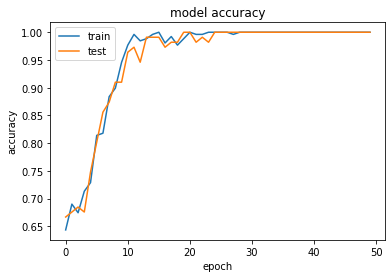

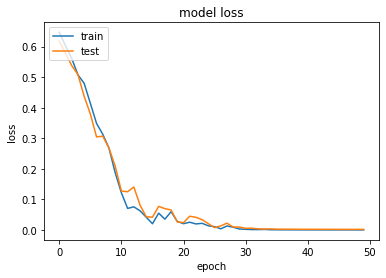

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
print(model_history.history.keys())
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **8. Save Model**

In [166]:
model.save('FR_SN.hdf5')